In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pygam import PoissonGAM, s,f, GAM, InvGaussGAM, te, l

# Load bike rental data with station information CSV file
bike_dat_raw = pd.read_csv("seoul_bike_rental_data_processed_2406.csv", encoding="cp949")

# Check the shape of processed data
bike_dat_raw.shape

(4984352, 29)

In [29]:
# Check irregular rides of 0 minutes used or 0 meters riden, Exclude them.
print((bike_dat_raw['use_meters']==0).value_counts())
print()
print((bike_dat_raw['use_minutes']==0).value_counts())

bike_dat = bike_dat_raw[(bike_dat_raw['use_meters']!=0) & (bike_dat_raw['use_minutes']!=0)].copy()
print()
print(bike_dat.shape)

False    4752525
True      231827
Name: use_meters, dtype: int64

False    4861062
True      123290
Name: use_minutes, dtype: int64

(4740293, 29)


In [31]:
# Add numeric forms of station IDs
station_id_num = np.concatenate([bike_dat['rent_station_id'].drop_duplicates(), bike_dat['return_station_id'].drop_duplicates()])
station_id_num = pd.Series(station_id_num).drop_duplicates().astype('category')
station_id_num = pd.DataFrame({'station_id': station_id_num, 'station_id_num': station_id_num.cat.codes})

bike_dat = bike_dat.merge(station_id_num.rename(columns={'station_id': 'rent_station_id', 'station_id_num': 'rent_station_id_num'}), how = 'left', on = 'rent_station_id')
bike_dat = bike_dat.merge(station_id_num.rename(columns={'station_id': 'return_station_id', 'station_id_num': 'return_station_id_num'}), how = 'left', on = 'return_station_id')

# Convert rent_is_weekend to numeric
bike_dat['rent_is_weekend'] = bike_dat['rent_is_weekend'].astype(int)

In [33]:
ride_counts = bike_dat.groupby(['rent_station_id_num', 'rent_station_latitude', 'rent_station_longitude', 'return_station_id_num', 'return_station_latitude', 'return_station_longitude'], as_index=False).size().rename(columns={'size': 'count'})

ride_counts['total'] = ride_counts.groupby(['rent_station_id_num', 'rent_station_latitude', 'rent_station_longitude'], as_index=False)['count'].transform('sum')

ride_counts['weight'] = ride_counts['count'] / ride_counts['total']

In [35]:
from scipy.sparse import coo_matrix

rows = ride_counts['rent_station_id_num'].to_numpy()
cols = ride_counts['return_station_id_num'].to_numpy()
weights = ride_counts['weight'].to_numpy()

ride_counts_matrix = coo_matrix((weights, (rows, cols))).toarray()

ride_counts_matrix

array([[0.07363636, 0.00045455, 0.00090909, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04868624, 0.00193199, ..., 0.00579598, 0.        ,
        0.0011592 ],
       [0.00042872, 0.00471597, 0.04866024, ..., 0.        , 0.00064309,
        0.05616292],
       ...,
       [0.        , 0.05236908, 0.00249377, ..., 0.02743142, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00306748,
        0.        ],
       [0.        , 0.00018643, 0.04101417, ..., 0.        , 0.        ,
        0.07568978]])

In [37]:
from sklearn.cluster import SpectralClustering

X = ride_counts_matrix

clustering = SpectralClustering(n_clusters=25,
        assign_labels='discretize',
        affinity='precomputed',
        random_state=2024).fit(X)

labels = clustering.labels_

C:\Users\Tae\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [39]:
clustering

SpectralClustering(affinity='precomputed', assign_labels='discretize',
                   n_clusters=25, random_state=2024)

In [41]:
df_clusters = pd.DataFrame({'cluster': labels})
df_clusters['rent_station_id_num'] = df_clusters.index
df_clusters


,cluster,rent_station_id_num
0,24,0
1,20,1
2,20,2
3,2,3
4,20,4
...,...,...
2735,20,2735
2736,20,2736
2737,20,2737
2738,20,2738


In [51]:
stations = ride_counts[['rent_station_id_num', 'rent_station_latitude', 'rent_station_longitude']].drop_duplicates()
stations = stations.merge(df_clusters, how='left', on='rent_station_id_num')

stations['cluster'] = stations['cluster'].astype(int)

In [59]:
# folium map visualizationsall
import requests
import json
import folium
import branca.colormap as cm

r = requests.get('https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json')
    
c = r.content
seoul_geo = json.loads(c)

In [53]:
stations['cluster'].value_counts()

0     205
18    195
2     188
8     185
23    183
17    143
24    135
15    123
14    121
20    119
9     115
13    105
1     104
5      90
3      85
6      82
12     77
4      72
19     67
16     67
21     66
10     60
11     58
22     55
7      34
Name: cluster, dtype: int64

In [65]:
# 16. folium map - predictions
from random import randint
colors = []
n = 25
for i in range(n):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

m = folium.Map(
    location=[37.55708, 126.9902],     
    zoom_start=12, 
    scrollWheelZoom=False,
    fill_opacity=0,
    tiles='cartodbpositron',      
)

folium.GeoJson(seoul_geo, name='지역구', fillOpacity= 0, weight = 0.6).add_to(m)

for idx, geo_df_row in stations.iterrows() :
    folium.Circle(radius=5, location=[geo_df_row['rent_station_latitude'], geo_df_row['rent_station_longitude']], color=colors[geo_df_row['cluster'].astype(int)]).add_to(m)
    
#colormap.caption = 'Predicted Bike Rentals'

#m.add_child(colormap)

m

In [67]:
bike_dat.columns

Index(['bike_id', 'rent_datetime', 'rent_station_number', 'rent_station_name',
       'rent_station_hold', 'return_datetime', 'return_station_number',
       'return_station_name', 'return_station_hold', 'use_minutes',
       'use_meters', 'user_birth_year', 'user_sex', 'user_type',
       'rent_station_id', 'return_station_id', 'bike_type', 'rent_date',
       'rent_hour', 'rent_weekday', 'rent_is_weekend', 'return_date',
       'return_hour', 'return_weekday', 'return_is_weekend',
       'rent_station_latitude', 'rent_station_longitude',
       'return_station_latitude', 'return_station_longitude',
       'rent_station_id_num', 'return_station_id_num'],
      dtype='object')

In [69]:
bike_dat['use_meters']

0             30.00
1            384.68
2            333.59
3            336.69
4            795.20
             ...   
4740288    10370.00
4740289    14586.61
4740290     4506.59
4740291     3800.52
4740292     1610.00
Name: use_meters, Length: 4740293, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


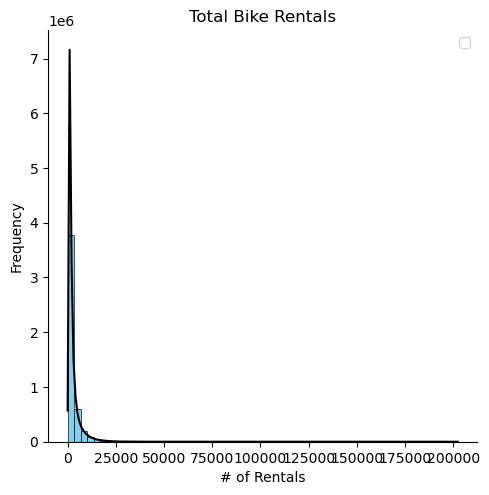

In [5]:
import seaborn as sns
#station_rent_counts = bike_dat.groupby(['rent_station_id'], as_index=False).size()
#station_rent_mean = station_rent_counts['size'].mean()

sns.displot(bike_dat['use_meters'], kde=True, bins = 60, color="black", facecolor='skyblue')
#plt.axvline(station_rent_mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {station_rent_mean:.1f}')

plt.title(f"Total Bike Rentals")
plt.xlabel("# of Rentals")
plt.ylabel("Frequency")
plt.legend(loc="upper right", shadow=False)

#plt.savefig('images/1_total_bike_rentals_each_station.png', bbox_inches='tight')
plt.show()

In [13]:
nonround_trips = bike_dat[bike_dat['rent_station_id_num'] != bike_dat['return_station_id_num']]
nonround_trips

,bike_id,rent_datetime,rent_station_number,rent_station_name,rent_station_hold,return_datetime,return_station_number,return_station_name,return_station_hold,use_minutes,...,return_date,return_hour,return_weekday,return_is_weekend,rent_station_latitude,rent_station_longitude,return_station_latitude,return_station_longitude,rent_station_id_num,return_station_id_num
1,SPB-43631,2024-06-01 00:00:31,1112,마곡엠밸리4단지 정문,0,2024-06-01 00:03:50,2702,마곡 엠밸리2단지,0.0,3,...,2024-06-01,0,5,True,37.568577,126.824776,37.569180,126.819443,2295,640
2,SPB-43767,2024-06-01 00:00:47,5055,마곡역5번출구앞,0,2024-06-01 00:03:58,1192,마곡수명산파크 209동 건너편,0.0,3,...,2024-06-01,0,5,True,37.559059,126.827049,37.555450,126.826897,1691,623
3,SPB-51016,2024-06-01 00:00:58,1257,가락시장역 사거리,0,2024-06-01 00:03:58,1203,밀리아나2빌딩 앞,0.0,3,...,2024-06-01,0,5,True,37.492100,127.117752,37.493729,127.120621,64,2490
4,SPB-40422,2024-06-01 00:00:28,3698,명일역 3번출구 옆,0,2024-06-01 00:04:10,1033,고덕동 아남아파트,0.0,3,...,2024-06-01,0,5,True,37.551426,127.144211,37.557934,127.144768,1888,45
5,SPB-65374,2024-06-01 00:00:29,2178,서울대학교 정문,0,2024-06-01 00:04:12,2143,서울산업정보학교,0.0,3,...,2024-06-01,0,5,True,37.467094,126.949326,37.470696,126.942200,476,2631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4740286,SPB-44125,2024-06-30 20:48:48,5768,방이삼거리,0,2024-07-01 08:49:19,2639,석촌역 8번출구,0.0,720,...,2024-07-01,8,0,False,37.512291,127.108253,37.505505,127.106575,2026,766
4740287,SPB-38913,2024-06-30 20:44:28,4217,한강공원 망원나들목,0,2024-07-01 09:07:53,565,옥수역 3번출구,0.0,743,...,2024-07-01,9,0,False,37.555576,126.896889,37.541367,127.017761,1712,2158
4740288,SPB-47642,2024-06-30 20:16:40,836,현대자동차서비스 앞,0,2024-07-01 09:08:01,565,옥수역 3번출구,0.0,771,...,2024-07-01,9,0,False,37.531422,126.951500,37.541367,127.017761,292,2158
4740289,SPB-38220,2024-06-30 04:13:56,1911,구로디지털단지역 앞,0,2024-07-01 09:34:31,4599,대림우성아파트 사거리,0.0,1760,...,2024-07-01,9,0,False,37.484940,126.901321,37.494846,126.900291,2430,1764


In [23]:
distance_trips = nonround_trips.groupby(['rent_station_id_num', 'return_station_id_num'], as_index=False)['use_meters'].median()
distance_trips

,rent_station_id_num,return_station_id_num,use_meters
0,0,1,7380.00
1,0,2,5380.67
2,0,5,8973.24
3,0,14,4750.00
4,0,85,7800.00
...,...,...,...
455403,2739,2621,8421.90
455404,2739,2661,7850.00
455405,2739,2662,4776.75
455406,2739,2735,2280.00


In [43]:
distance_trips = distance_trips.merge(df_clusters, how='left', on='rent_station_id_num')
distance_trips = distance_trips.merge(df_clusters.rename(columns={'rent_station_id_num':'return_station_id_num'}), how='left', on='return_station_id_num')
distance_trips

,rent_station_id_num,return_station_id_num,use_meters,cluster_x,cluster_y
0,0,1,7380.00,24,20
1,0,2,5380.67,24,20
2,0,5,8973.24,24,20
3,0,14,4750.00,24,20
4,0,85,7800.00,24,22
...,...,...,...,...,...
455403,2739,2621,8421.90,20,16
455404,2739,2661,7850.00,20,0
455405,2739,2662,4776.75,20,16
455406,2739,2735,2280.00,20,20


In [47]:
distance_clusters = distance_trips.groupby(['cluster_x', 'cluster_y'], as_index=False).transform({
    'Value1': ('use_meters', 'mean'),   
    'Value1': ('use_meters', 'mean'),
    'Value1': ('use_meters', 'mean')
}))
distance_clusters

,cluster_x,cluster_y,use_meters
0,0,0,3009.686564
1,0,1,27571.696250
2,0,2,9180.520659
3,0,3,26209.300476
4,0,4,12613.183757
...,...,...,...
531,24,20,9678.815691
532,24,21,22493.272000
533,24,22,4703.187725
534,24,23,14842.466094


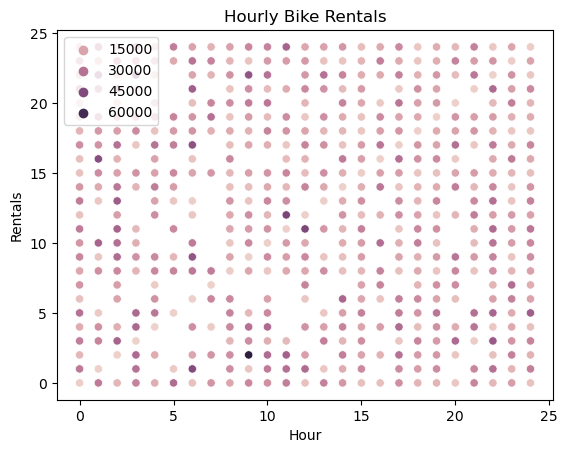

In [49]:
sns.scatterplot(data=distance_clusters, x='cluster_x', y='cluster_y', hue='use_meters')

plt.title("Hourly Bike Rentals")
plt.xlabel("Hour")
plt.ylabel("Rentals")
plt.legend(loc='upper left')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


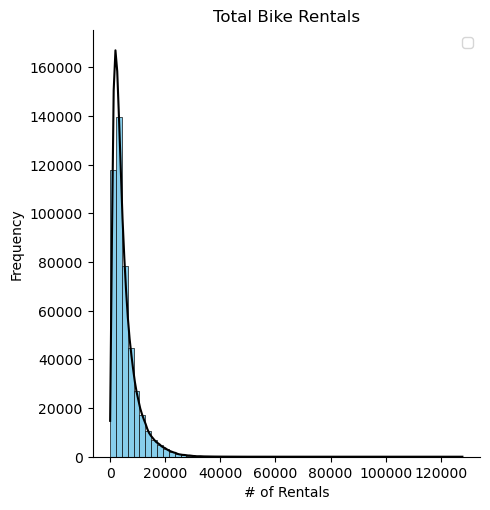

In [21]:
import seaborn as sns
#station_rent_counts = bike_dat.groupby(['rent_station_id'], as_index=False).size()
#station_rent_mean = station_rent_counts['size'].mean()

sns.displot(distance_trips['use_meters'], kde=True, bins = 60, color="black", facecolor='skyblue')
#plt.axvline(station_rent_mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {station_rent_mean:.1f}')

plt.title(f"Total Bike Rentals")
plt.xlabel("# of Rentals")
plt.ylabel("Frequency")
plt.legend(loc="upper right", shadow=False)

#plt.savefig('images/1_total_bike_rentals_each_station.png', bbox_inches='tight')
plt.show()